## Hyperparameter-Informed Predictive Exploration (HIPE) for Bayesian Optimization Initialization

#### This notebook demonstrates the use of the `qHyperparameterInformedPredictiveExploration` (HIPE) acquisition function for initializing Bayesian optimization, as described in the paper "Informed Initialization for Bayesian Optimization and Active Learning".
---

Bayesian Optimization (BO) is a powerful framework for optimizing expensive black-box functions. The quality of the surrogate model, especially in the few-shot setting, is crucial for good optimization performance. The HIPE acquisition function intelligently initializes BO by balancing:

- **Predictive uncertainty reduction** across the design space (Expected Predictive Information Gain - EPIG)
- **Reduction of hyperparameter uncertainty** (Bayesian Active Learning by Disagreement - BALD)

This notebook walks through two examples using HIPE for initialization:

- **Example 1:** Testrun of what HIPE initialization may look like
- **Example 2:** Embedded Branin in 8D using a SAAS prior

Implementation reference:  
- Paper: "Informed Initialization for Bayesian Optimization and Active Learning" (Hvarfner et al., NeurIPS 2025)
- Code: `botorch_community/acquisition/bayesian_active_learning.py`

In [96]:
import matplotlib.pyplot as plt
import torch
from botorch.acquisition import qLogNoisyExpectedImprovement
from botorch.fit import fit_fully_bayesian_model_nuts
from botorch.models.fully_bayesian import SaasFullyBayesianSingleTaskGP
from botorch.optim import optimize_acqf
from botorch.test_functions import Branin
from botorch.utils.sampling import draw_sobol_samples
from botorch_community.acquisition.bayesian_active_learning import (
    qExpectedPredictiveInformationGain,
    qHyperparameterInformedPredictiveExploration,
)

In [118]:
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms import Normalize

SMOKE_TEST = False
if SMOKE_TEST:
    model_fit_kwargs = {
        "num_samples": 8,
        "thinning": 4,
        "warmup_steps": 4,
        "disable_progbar": True,
    }
else:
    # These are not the recommended model_fit_kwargs (the default kwargs are
    # better-performing). If you are to benchmark the method on general problems,
    # it is recommended to not pass model_fit_kwargs at all. However, this works
    # for simpler example and makes the notebook run quicker.
    model_fit_kwargs = {
        "num_samples": 128,
        "thinning": 8,
        "warmup_steps": 256,
        "disable_progbar": True,
    }


# pyre-ignore
def get_fully_bayesian_model(
    train_X: torch.Tensor, train_Y: torch.Tensor, bounds: torch.Tensor
) -> SaasFullyBayesianSingleTaskGP:
    """Create a SaasFullyBayesianSingleTaskGP model. We can't standardize
    observations if we don't have data, but otherwise we should standardize."""
    model = SaasFullyBayesianSingleTaskGP(
        train_X=train_X,
        train_Y=train_Y,
        input_transform=Normalize(d=train_X.shape[-1], bounds=bounds),
        outcome_transform=None if len(train_X) == 0 else Standardize(m=1),
    )
    fit_fully_bayesian_model_nuts(model, **model_fit_kwargs)
    return model

<a id="hipe-overview"></a>
## 3. HIPE Acquisition Function Overview

The HIPE acquisition function is computed as:

```python
# HIPE(X) = EPIG(X) + beta * BALD(X)
```

where `beta` can be either fixed or automatically tuned.

- **BALD(X):** Bayesian Active Learning by Disagreement, focuses on hyperparameter uncertainty reduction.
- **EPIG(X):** Expected Predictive Information Gain, focuses on reducing predictive uncertainty across the search space.

**Key parameters:**
- `model`: Fully Bayesian GP model (`SaasFullyBayesianSingleTaskGP`)
- `mc_points`: Test set points for information gain computation. May be non-uniform, if the user wants to target certain parts of the search space more than others. In our experiments, we will resort to a uniform distribution to ensure even spread throughout the search space.
- `bounds`: Design space bounds for beta tuning

Implementation:  
`botorch_community/acquisition/bayesian_active_learning.py`

### The Initialization Challenge in Bayesian Optimization

In few-shot Bayesian Optimization, where we can only evaluate a small number of batches, the **initialization strategy** is critical. Traditional approaches use space-filling designs like Sobol sequences or Latin Hypercube Sampling to achieve broad coverage of the input space. However, these methods have two key limitations:

1. **Space-filling ≠ Informative**: Uniform coverage doesn't necessarily reduce predictive uncertainty where it matters most
2. **Hyperparameter Learning**: They ignore the need to learn model hyperparameters (e.g., lengthscales in GPs) that are crucial for subsequent optimization

### The HIPE Approach

HIPE (Hyperparameter-Informed Predictive Exploration) addresses both challenges by balancing two complementary objectives:

**1. Predictive Uncertainty Reduction (EPIG - Expected Predictive Information Gain)**

This component ensures we select points that reduce uncertainty across the search space:

$$\text{EPIG}(\mathbf{X}) = -\mathbb{E}_{\boldsymbol{\theta}, y(\mathbf{X})}\left[\mathbb{E}_{\mathbf{x}_*}\left[\mathcal{H}\left[y(\mathbf{x}_*) \mid \boldsymbol{\theta}, y(\mathbf{X})\right]\right]\right]$$

where $\mathcal{H}$ is the entropy, $\boldsymbol{\theta}$ are the model hyperparameters, and $\mathbf{x}_*$ are test points sampled uniformly from the domain.

**2. Hyperparameter Learning (BALD - Bayesian Active Learning by Disagreement)**

This component selects points that maximize information gain about the model hyperparameters:

$$\text{BALD}(\mathbf{X}) = \mathcal{H}[y(\mathbf{X})] - \mathbb{E}_{\boldsymbol{\theta}}\left[\mathcal{H}[y(\mathbf{X}) \mid \boldsymbol{\theta}]\right]$$

BALD identifies locations where models with different hyperparameters disagree most, helping to resolve uncertainty in lengthscales, noise variance, and other parameters.

### Combining the Objectives

HIPE combines these two objectives with a tuning factor $\beta$:

$$\text{HIPE}(\mathbf{X}) = \text{EPIG}(\mathbf{X}) + \beta \cdot \text{BALD}(\mathbf{X})$$

The key insight is that $\beta$ should reflect **how much hyperparameter information translates to predictive information**. This is quantified by the mutual information between hyperparameters and test predictions:

$$\beta = \text{EIG}(y(\mathbf{x}_*); \boldsymbol{\theta} \mid \mathcal{D}) = \mathbb{E}_{\mathbf{x}_*}\left[\mathcal{H}[y(\mathbf{x}_*) \mid \mathcal{D}] - \mathbb{E}_{\boldsymbol{\theta}}[\mathcal{H}[y(\mathbf{x}_*) \mid \boldsymbol{\theta}, \mathcal{D}]]\right]$$

This choice of $\beta$ automatically balances the two objectives without requiring manual tuning.

### Why This Works

- **BALD alone** tends to select axis-aligned queries to resolve lengthscales, sacrificing coverage
- **EPIG alone** (similar to NIPV) spreads points well but ignores hyperparameter learning
- **HIPE** achieves both: points are well-distributed AND aligned with axes of uncertainty

The result is an initialization that produces:
- ✅ Better-calibrated surrogate models
- ✅ More accurate hyperparameter estimates (more often than not)
- ✅ Improved subsequent BO performance  (hopefully)

## Visualizing Initialization Strategies

Let's compare how Sobol and HIPE initialize a batch of points on a 2D test function. This visualization will help us understand the different behaviors of these initialization strategies.

In [ ]:
function = Branin(negate=True)

torch.manual_seed(42)
dtype = torch.float64
batch_size = 6
# Generate Sobol initialization
sobol_X = (
    draw_sobol_samples(
        bounds=function.bounds,
        n=batch_size,
        q=1,
    )
    .squeeze(-2)
    .to(dtype=dtype)
)

# Generate HIPE initialization
# The GP is empty at the start, but we still need to pass in zero-D tensors
train_X = torch.zeros(0, function.dim, dtype=dtype)
train_Y = function(train_X).unsqueeze(-1)

print(train_X.shape, train_Y.shape)

torch.Size([0, 2]) torch.Size([0, 1])


In [127]:
from botorch.generation.gen import gen_candidates_torch
import warnings

model = get_fully_bayesian_model(
    train_X=train_X, train_Y=train_Y, bounds=function.bounds
)

# Generate the empirical test distribution for HIPE - let's use uniform
mc_points = (
    draw_sobol_samples(
        bounds=function.bounds,
        n=256,
        q=1,
    )
    .squeeze(-2)
    .to(dtype=dtype)
)

# Note: q is not passed to the constructor; it is inferred from the input X during forward pass
epig = qExpectedPredictiveInformationGain(
    model=model,
    mc_points=mc_points,
)

# Note: q is not passed to the constructor; it is inferred from the input X during forward pass
hipe = qHyperparameterInformedPredictiveExploration(
    model=model, mc_points=mc_points, bounds=function.bounds
)

# Suppressing warnings during optimization - this stems from the fact that in 2D with a SAAS
# prior, the entire space is explored and there is little to no predictive uncertainty left.
# Thus, the acquisition function has very small gradients.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    candidates_hipe, _ = optimize_acqf(
        acq_function=hipe,
        bounds=function.bounds,
        q=batch_size,
        num_restarts=1,
        raw_samples=128,
        options={"batch_limit": 32},
        gen_candidates=gen_candidates_torch,
    )

    candidates_epig, _ = optimize_acqf(
        acq_function=epig,
        bounds=function.bounds,
        q=batch_size,
        num_restarts=1,
        raw_samples=128,
        options={"batch_limit": 32},
        gen_candidates=gen_candidates_torch,
    )

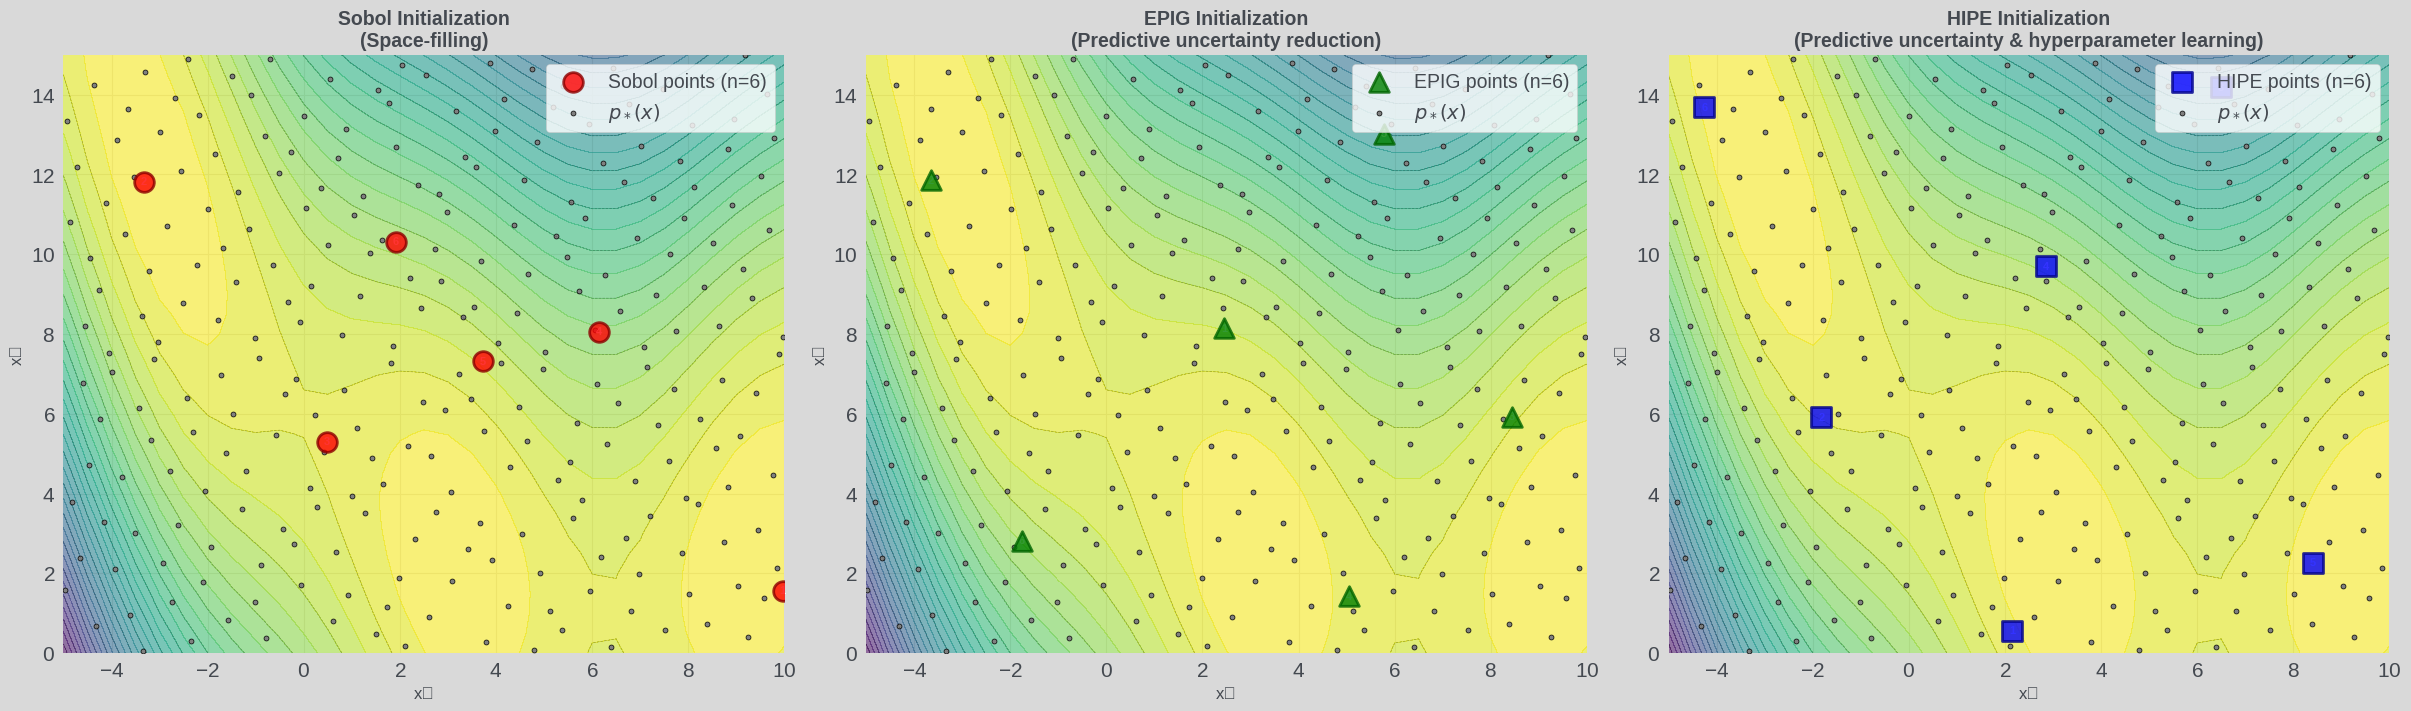

In [ ]:
# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(24, 7), layout="constrained")
GRID_SIZE = 31
# Create grid for contour plot
x1 = torch.linspace(function.bounds[0, 0], function.bounds[1, 0], GRID_SIZE)
x2 = torch.linspace(function.bounds[0, 1], function.bounds[1, 1], GRID_SIZE)
X1, X2 = torch.meshgrid(x1, x2, indexing="ij")
grid_X_eval = torch.stack([X1.flatten(), X2.flatten()], dim=-1)
Z = function(grid_X_eval).reshape(GRID_SIZE, GRID_SIZE)
with torch.no_grad():
    # Initialize Sobol, EPIG and HIPE plot settings
    init_config = [
        {
            "points": sobol_X,
            "title": "Sobol Initialization\n(Space-filling)",
            "color": "red",
            "marker": "o",
            "edgecolor": "darkred",
            "label": f"Sobol points (n={batch_size})",
        },
        {
            "points": candidates_epig,
            "title": "EPIG Initialization\n(Predictive uncertainty reduction)",
            "color": "green",
            "marker": "^",
            "edgecolor": "darkgreen",
            "label": f"EPIG points (n={batch_size})",
        },
        {
            "points": candidates_hipe,
            "title": "HIPE Initialization\n(Predictive uncertainty & hyperparameter learning)",
            "color": "blue",
            "marker": "s",
            "edgecolor": "darkblue",
            "label": f"HIPE points (n={batch_size})",
        },
    ]

    # Plot initialization strategies
    for ax, config in zip(axes, init_config):
        contour = ax.contourf(
            X1.numpy(), X2.numpy(), Z.numpy(), levels=30, cmap="viridis", alpha=0.6
        )
        ax.contour(
            X1.numpy(),
            X2.numpy(),
            Z.numpy(),
            levels=15,
            colors="black",
            alpha=0.3,
            linewidths=0.5,
        )

        ax.scatter(
            config["points"][:, 0].numpy(),
            config["points"][:, 1].numpy(),
            c=config["color"],
            s=200,
            marker=config["marker"],
            edgecolors=config["edgecolor"],
            linewidths=2,
            label=config["label"],
            zorder=5,
            alpha=0.8,
        )

        # Add numbers to points
        for i, (x, y) in enumerate(config["points"].numpy()):
            ax.annotate(
                str(i + 1),
                (x, y),
                fontsize=8,
                ha="center",
                va="center",
                color="white",
                weight="bold",
            )

        # Scatter mc_points
        ax.scatter(
            mc_points[:, 0].numpy(),
            mc_points[:, 1].numpy(),
            c="grey",
            s=50,
            marker=".",
            edgecolors="k",
            zorder=1,
            alpha=1,
            label="$p_*(x)$"
        )

        ax.set_xlabel("x₁", fontsize=12)
        ax.set_ylabel("x₂", fontsize=12)
        ax.set_title(config["title"], fontsize=14, weight="bold")
        ax.legend(loc="upper right", fontsize=14)
        ax.set_xlim(*function.bounds[:, 0])
        ax.set_ylim(*function.bounds[:, 1])

    plt.show()

### Understanding the Initialization Patterns

**Sobol Initialization (Red Circles):**
- Uniform coverage using low-discrepancy sequence
- May leave uneven gaps

**EPIG (Green Triangles):**
- Ensures points spread to reduce predictive uncertainty
- Reduces predictive entropy over grey points, on average

**HIPE (Blue Squares):**
- Points chosen for maximum information gain about function and hyperparameters
- Reduces predictive entropy over grey points and reduces hyperparameter entropy


In [101]:
def initialize_with_hipe(
    model: SaasFullyBayesianSingleTaskGP,
    objective,
    mc_points: torch.Tensor,
    q: int,
    seed: int = 42,
) -> tuple[torch.Tensor, torch.Tensor]:
    """Initialize BO with HIPE acquisition function."""
    torch.manual_seed(seed)

    # Note: q is not passed to constructor; it's inferred from input X during forward
    acq_func = qHyperparameterInformedPredictiveExploration(
        model=model,
        mc_points=mc_points,
        bounds=objective.bounds,
    )

    candidates, acq_value = optimize_acqf(
        acq_function=acq_func,
        bounds=objective.bounds,
        q=q,
        num_restarts=4,
        raw_samples=256,
        options={"batch_limit": 32},
    )

    new_Y = objective(candidates).unsqueeze(-1)
    return candidates, new_Y

In [102]:
# Define a function to plot lengthscales
def plot_lengthscales(lengthscales: torch.Tensor, title: str):
    with torch.no_grad():
        dim = lengthscales.shape[-1]
        plt.figure(figsize=(10, 5))
        plt.boxplot(torch.log(lengthscales).squeeze(-2), patch_artist=True, boxprops=dict(facecolor='skyblue'))
        plt.xlabel('Dimensions')
        plt.ylabel('Log Lengthscale')
        plt.title(title)
        plt.xticks(range(1, dim+1), labels=[f'Dim {i+1}' for i in range(dim)])
        plt.show()

In [103]:
def get_bo_batch(
    model: SaasFullyBayesianSingleTaskGP,
    objective,
    q: int,
    seed: int = 42,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """Obtain a batch of candidates for Bayesian optimization."""
    torch.manual_seed(seed)

    acq_func = qLogNoisyExpectedImprovement(
        model=model,
        X_baseline=model.train_inputs[0],
        prune_baseline=True,
    )

    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=objective.bounds,
        q=q,
        num_restarts=4,
        raw_samples=512,
        options={"batch_limit": 64, "sample_around_best": True},
    )

    new_Y = objective(candidates).unsqueeze(-1)
    return candidates, new_Y

<a id="example-branin"></a>
## 7. Example 1: 2D Branin Function

In this example, we'll optimize a 10D-embedded 2D Branin function using HIPE initialization with auto-tuned $\beta$.

In [104]:
from botorch.test_functions.synthetic import SyntheticTestFunction
from torch import Tensor


class Embedded(SyntheticTestFunction):
    def __init__(
        self,
        function: SyntheticTestFunction,
        dim: int,
        noise_std: float = 0.0,
        negate: bool = False,
        bounds: Tensor | None = None,
    ) -> None:
        r"""
        Args:
            dim: The (input) dimension.
            noise_std: Standard deviation of the observation noise.
            negate: If True, negate the function.
            bounds: Custom bounds for the function specified as (lower, upper) pairs.
        """
        assert (
            dim >= function.dim
        ), "The effective function dimensionality is larger than the embedding dimension."
        self.continuous_inds = list(range(dim))
        self.dim = dim
        self._bounds = [(0.0, 1.0) for _ in range(self.dim)]
        self._bounds[0 : function.dim] = function._bounds
        super().__init__(noise_std=noise_std, negate=negate, bounds=bounds)
        self.register_buffer(
            "i", torch.tensor(tuple(range(1, self.dim + 1)), dtype=torch.float)
        )
        self.embedded_function = function

    def _evaluate_true(self, X: Tensor) -> Tensor:
        embedded_X = X[:, 0 : self.embedded_function.dim]
        return self.embedded_function.evaluate_true(embedded_X)

objective = Embedded(Branin(), dim=8, negate=True, noise_std=0.1)

In [105]:
# Run the optimization loop (3 batches of 12 points each) with both HIPE and Sobol as initialization

In [ ]:
batch_size = 8
num_bo_batches = 2

# Create the empirical test distribution for HIPE
mc_points = draw_sobol_samples(
    bounds=objective.bounds,
    n=384,
    q=1,
).squeeze(-2)

model = get_fully_bayesian_model(
    train_X=torch.empty(0, objective.dim, dtype=dtype),
    train_Y=torch.empty(0, 1, dtype=dtype),
    bounds=objective.bounds,
)
init_X, init_Y = initialize_with_hipe(
    model=model,
    objective=objective,
    mc_points=mc_points,
    q=batch_size,
)

train_X = init_X.clone()
train_Y = init_Y.clone()

for batch_idx in range(num_bo_batches):
    hipe_init_model = get_fully_bayesian_model(train_X, train_Y, bounds=objective.bounds)

    batch_X, batch_Y = get_bo_batch(
        model=hipe_init_model,
        objective=objective,
        q=batch_size,
    )
    # report new best value
    train_X = torch.cat([train_X, batch_X])
    train_Y = torch.cat([train_Y, batch_Y])
    print(f"Best value found: {train_Y.max().item():.3f}")

Sample: 100%|██████████| 384/384 [00:11, 33.84it/s, step size=4.98e-01, acc. prob=0.893]



[W 251209 06:31:13 optimize:789] Optimization failed in `gen_candidates_scipy` with the following warning(s):
    [OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .')]
    Trying again with a new set of initial conditions.


Sample: 100%|██████████| 384/384 [00:24, 15.54it/s, step size=3.01e-01, acc. prob=0.928]



Best value found: -0.459


Sample: 100%|██████████| 384/384 [00:27, 13.93it/s, step size=3.52e-01, acc. prob=0.943]



Best value found: -0.459


In [ ]:
# Sobol Initialization
sobol_X = draw_sobol_samples(
    bounds=objective.bounds,
    n=batch_size,
    q=1,
).squeeze(-2).to(dtype=dtype)
sobol_Y = objective(sobol_X).unsqueeze(-1)


train_X = sobol_X.clone()
train_Y = sobol_Y.clone()

for batch_idx in range(num_bo_batches):
    sobol_init_model = get_fully_bayesian_model(train_X, train_Y, bounds=objective.bounds)

    batch_X, batch_Y = get_bo_batch(
        model=sobol_init_model,
        objective=objective,
        q=batch_size,
    )
    # report new best value
    train_X = torch.cat([train_X, batch_X])
    train_Y = torch.cat([train_Y, batch_Y])
    print(f"Best value found: {train_Y.max().item():.3f}")

Sample: 100%|██████████| 384/384 [00:24, 15.91it/s, step size=3.83e-01, acc. prob=0.911]



Best value found: -4.555


Sample: 100%|██████████| 384/384 [00:27, 14.08it/s, step size=3.09e-01, acc. prob=0.926]



Best value found: -4.555


### Lengthscale Visualization

The plots display key differences in lengthscales from HIPE and Sobol initializations. For embedded Branin, we want the first two dimensions to have consistently short lengthscales, and the other dimensions to have as long lengthscales as possible.

- **HIPE Initialization:**
  - More frequently identifies the 2 active dimensions (the first two)
  - Other lengthscales are usually consistently long (may vary across seeds)

- **Sobol Initialization:**
  - Active dimensions are generally less well identified
  - Non-active dimensions may have short lengthscales, resulting in more wasted evaluations.

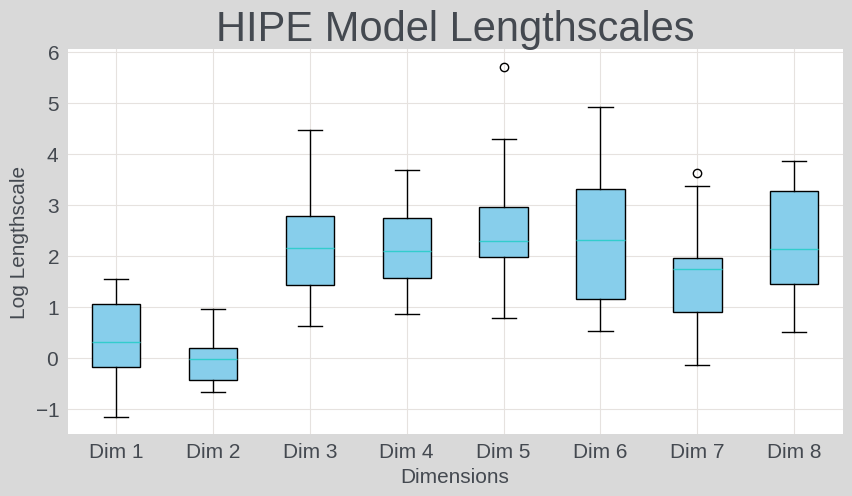

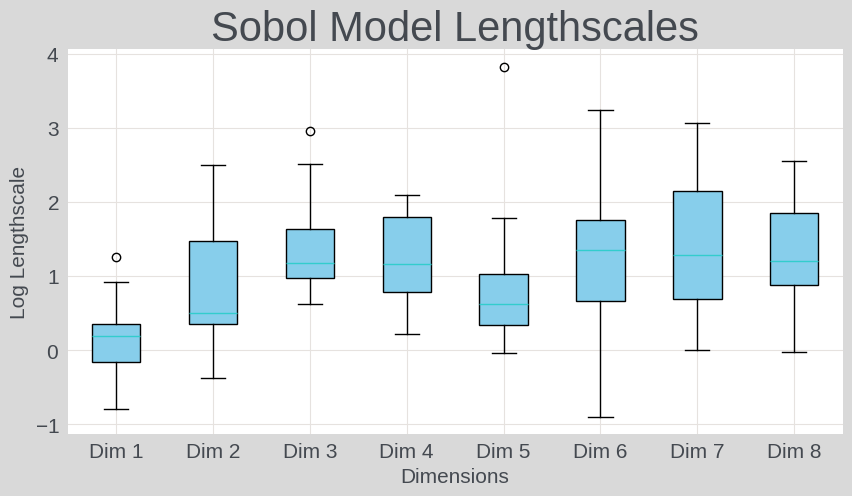

In [ ]:
# Extract lengthscales from HIPE initialized model and plot
hipe_lengthscales = hipe_init_model.covar_module.base_kernel.lengthscale
plot_lengthscales(hipe_lengthscales, "HIPE Model Lengthscales")

# Extract lengthscales from Sobol initialized model and plot
sobol_lengthscales = sobol_init_model.covar_module.base_kernel.lengthscale
plot_lengthscales(sobol_lengthscales, "Sobol Model Lengthscales")

### Plotting Out-of-sample predictive performance after initialization
The HIPE-initialized model (generally, but not always)
- achieves better predictions compared to the Sobol-initialized model 
- the improvement can be attributed to HIPE's ability to generate better hyperparameter estimates while distributing data evenly

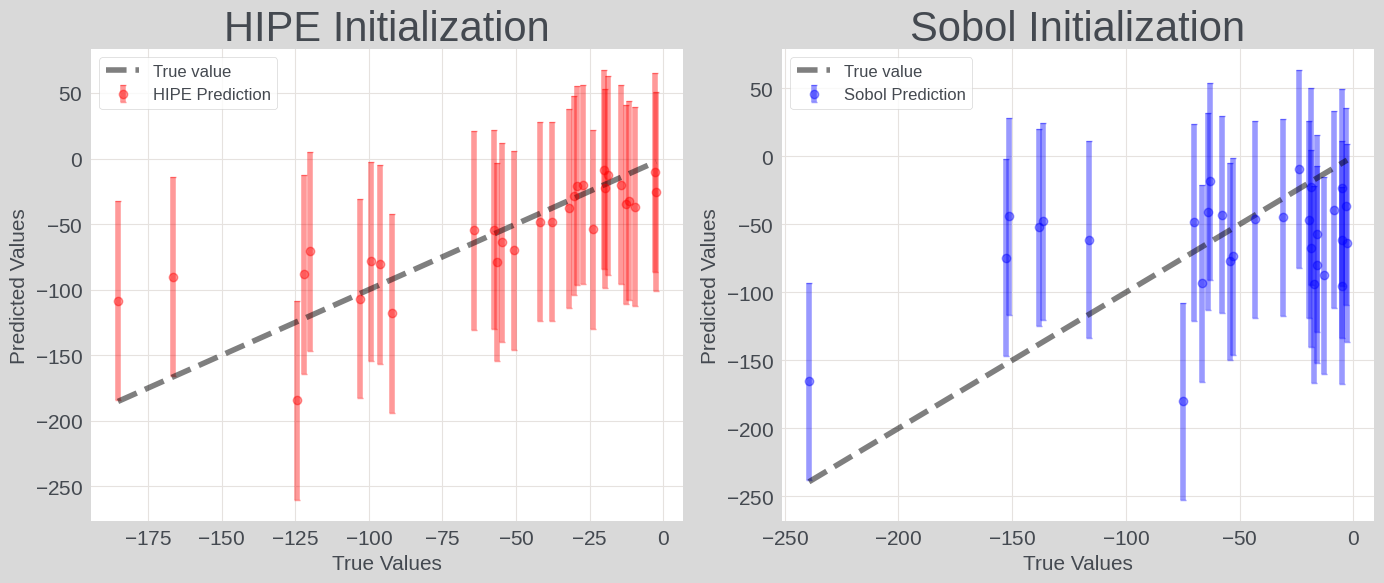

In [ ]:
@torch.no_grad()
def plot_predictions(model, objective, ax, title, color, label):
    # Generate random test data
    test_X = draw_sobol_samples(bounds=objective.bounds, n=30, q=1).squeeze(-2).to(dtype=dtype)
    true_Y = objective(test_X).unsqueeze(-1).flatten()

    pred = model.posterior(test_X)
    mean = pred.mixture_mean.squeeze(-1).flatten()
    lower, upper = mean - 1.96 * pred.mixture_variance.sqrt(), mean + 1.96 * pred.mixture_variance.sqrt()
    lower = lower.flatten()
    upper = upper.flatten()

    # Sort the test data by true_Y for plotting
    sorted_indices = true_Y.argsort().flatten()
    true_Y_sorted = true_Y[sorted_indices]
    mean_sorted = mean[sorted_indices]
    lower_sorted = lower[sorted_indices]
    upper_sorted = upper[sorted_indices]

    ax.errorbar(
        true_Y_sorted, mean_sorted, yerr=(upper_sorted - mean_sorted), fmt=f'{color}o',
        label=f'{label} Prediction', ecolor=color, alpha=0.4, capsize=2, linestyle='none'
    )
    ax.plot(true_Y_sorted, true_Y_sorted, 'k--', label='True value', alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel("True Values")
    ax.set_ylabel("Predicted Values")
    ax.legend()

# Evaluate and plot for HIPE and Sobol initialized models
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

plot_predictions(hipe_init_model, objective, axes[0], "HIPE Initialization", 'r', 'HIPE')
plot_predictions(sobol_init_model, objective, axes[1], "Sobol Initialization", 'b', 'Sobol')

plt.tight_layout()
plt.show()